In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats


## Load Data

In [90]:
df = pd.read_csv('/Users/ajiths/PycharmProjects/A/B_Testing/DataFile/AB_Test_Results.csv')
# kaggle source: https://www.kaggle.com/datasets/sergylog/ab-test-data/data

In [91]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


# Hypothesis
**Null Hypothesis**: There is no difference between revenue per user between control and variant groups
**Alternate Hypothesis**: There is a statistically significant difference in the revenue per user between the groups

*Alpha: 0.05 (95% significance level)*

### Find if there are users in both control and variant


In [92]:
grouped_df = df.groupby('USER_ID').agg(number_variants =('VARIANT_NAME','nunique')).reset_index()
users_with_both_variants = grouped_df.loc[grouped_df['number_variants']>1,'USER_ID']
len(users_with_both_variants)

    

1541

In [93]:
df['USER_ID'].nunique()

6324

#### Out of 6324 user_id, 1541 cannot be used for analysis since they are in both groups 

In [94]:
removed_user_data = ~df['USER_ID'].isin(users_with_both_variants)
experiment_group = df.loc[removed_user_data]

## Summary of the experiment

In [95]:
experiment_summary = experiment_group.groupby("VARIANT_NAME").agg(user_count=("USER_ID","nunique"),total_revenue=("REVENUE","sum")).reset_index()
print(experiment_summary)

  VARIANT_NAME  user_count  total_revenue
0      control        2390         470.56
1      variant        2393         179.32


## Statistical Analysis

In [96]:
control_revenue = experiment_group.loc[experiment_group['VARIANT_NAME']=="control"]
variant_revenue = experiment_group.loc[experiment_group['VARIANT_NAME']=="variant"]

In [97]:
def calculate_t_test(control_revenue_data, variant_revenue_data, alpha=0.05):
    """
    Perform an independent t-test to compare means between two groups.

    Parameters:
    - control_revenue_data: List or array of revenue numbers for the control group.
    - variant_revenue_data: List or array of revenue numbers for the variant group.
    - alpha: Significance level (default is 0.05).

    Returns:
    - t_statistic: The t-statistic of the t-test.
    - p_value: The p-value of the t-test.
    - significant: Boolean indicating whether the difference in means is statistically significant.
    """

    # Calculate mean and standard deviation for each group
    control_avg_revenue = np.mean(control_revenue_data['REVENUE'])
    control_std_dev = np.std(control_revenue_data['REVENUE'], ddof=1)
    variant_avg_revenue = np.mean(variant_revenue_data['REVENUE'])
    variant_std_dev = np.std(variant_revenue_data['REVENUE'], ddof=1)

    # Perform independent t-test
    t_statistic, p_value = stats.ttest_ind_from_stats(mean1=control_avg_revenue,
                                                      std1=control_std_dev,
                                                      nobs1=len(control_revenue_data),
                                                      mean2=variant_avg_revenue,
                                                      std2=variant_std_dev,
                                                      nobs2=len(variant_revenue_data))

    # Check if the difference in means is statistically significant
    significant = p_value < alpha

    return t_statistic, p_value, significant

In [98]:
 t_statistic, p_value, significance = calculate_t_test(control_revenue,variant_revenue,alpha=0.05)

In [99]:
print( t_statistic, p_value, significance)

1.4075950071478767 0.15930224976746454 False


## Plotting the revenue from the 2 groups

Text(0.5, 1.0, 'Control group Revenue Distribution')

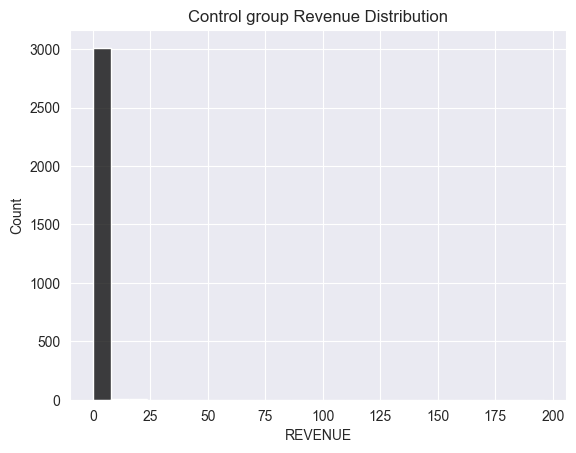

In [100]:
sns.histplot(data=control_revenue, bins=25, color='k',x='REVENUE')
plt.title("Control group Revenue Distribution")

Text(0.5, 1.0, 'Variant group Revenue Distribution')

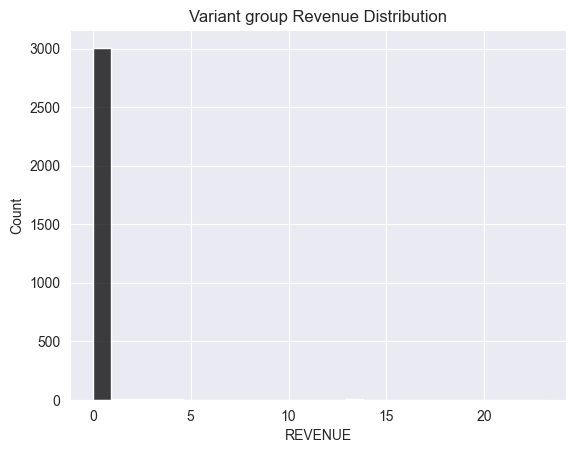

In [101]:
sns.histplot(data=variant_revenue, bins=25, color='k',x='REVENUE')
plt.title("Variant group Revenue Distribution")


Text(0.5, 1.0, 'Box plot distribution between variant and control group')

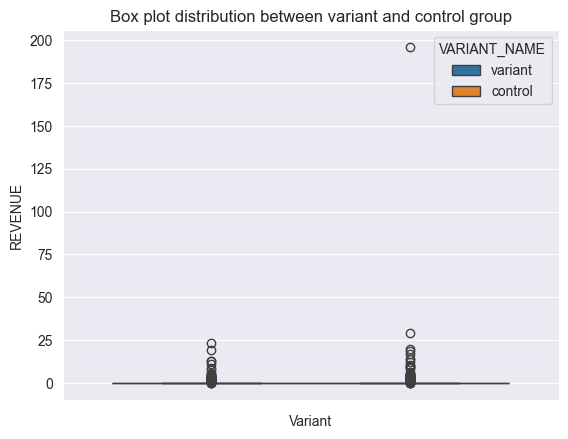

In [102]:
sns.boxplot(data=experiment_group,y="REVENUE",hue="VARIANT_NAME")
plt.xlabel("Variant")
plt.title("Box plot distribution between variant and control group")

## Limiting to users that have greater than 0 revenue and removing the user that has revenue of larger than 150

In [103]:
revenue_users = experiment_group.loc[(experiment_group['REVENUE']>0)&(experiment_group['REVENUE']<150),]

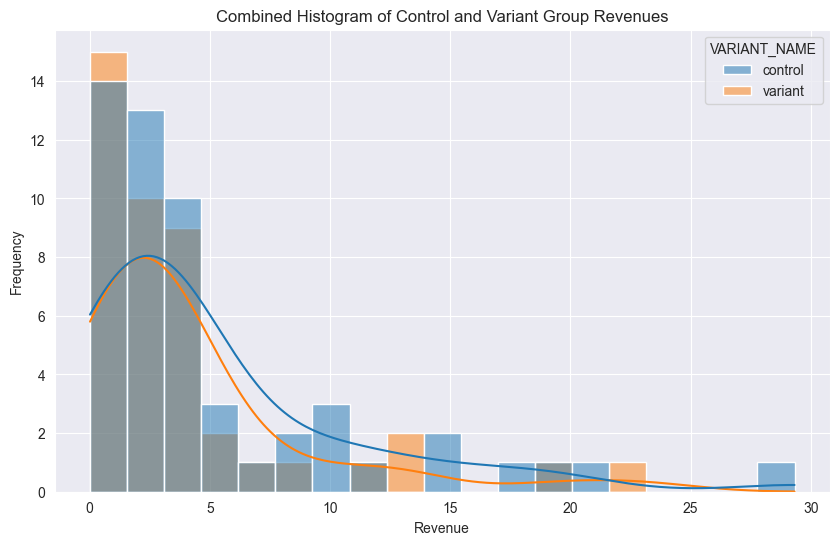

In [104]:
# Plot combined histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=revenue_users, x='REVENUE', hue='VARIANT_NAME', kde=True)
plt.title('Combined Histogram of Control and Variant Group Revenues')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()


Text(0.5, 0, 'Variants')

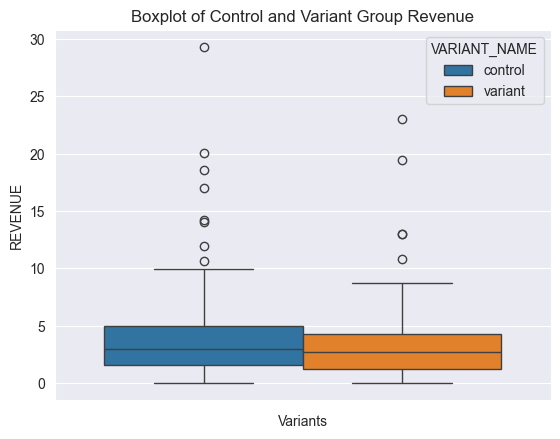

In [105]:
sns.boxplot(data=revenue_users,y="REVENUE",hue="VARIANT_NAME")
plt.title('Boxplot of Control and Variant Group Revenue')
plt.xlabel('Variants')
